# Kardiomiopatia Przerostowa

In [1]:
import cv2
import skimage.io as io
import matplotlib.pyplot as plt
import src.show as show

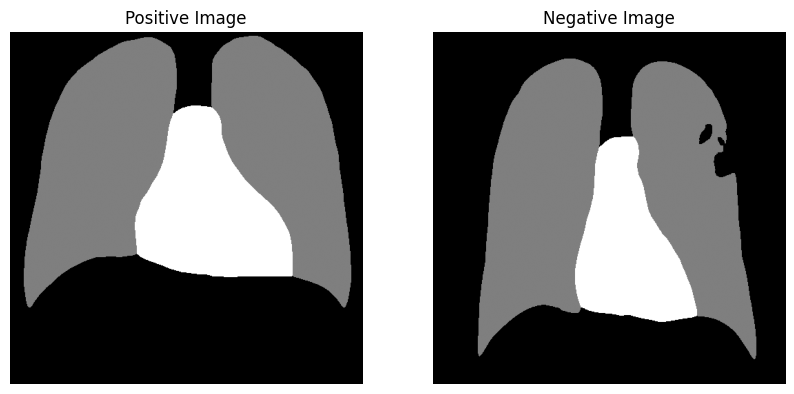

In [2]:
positive = io.imread("data\\11KB.png")
negative = io.imread("data\\17MB.png")

show.show_together(positive, "Positive Image", negative, "Negative Image")

# Jak wygląda diagnostyka teraz
Standardem diagnostyki kardiomiopatii przerostwoej na podstawie CT klastki piersowiej jest pomiar najdłuższej lini serca i płuc. Natępnie podzielnie ich przez siebie, jeżeli otrzymany wynik jest większy niż 0.5 to uznaje się że pacjent cierpi na kardiomiopatie przerostową (przypadek pozytywny)


In [3]:
import src.standard as std

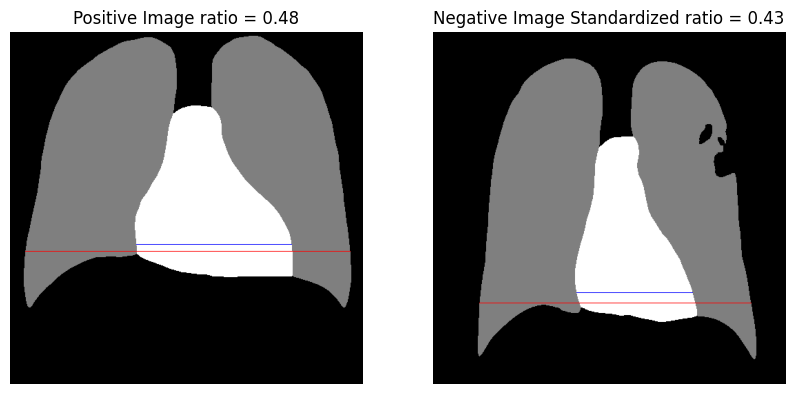

In [4]:
positive_result = std.lines_ratio(positive)
negative_result = std.lines_ratio(negative)

show.show_together(positive_result["img"], f"Positive Image ratio = {positive_result['ratio']}", 
                   negative_result["img"], f"Negative Image Standardized ratio = {negative_result['ratio']}")

### skuteczność metody
Na podstawie naszych danych ustaliliśmy, że metoda ta poprawnie rozpoznaje poniżej 50% przypadków kardiomiopatii przerostowej

# KN AI MED AGH - czym się właściwie zajmujemy 
Naszym celem jest właśnie poprawienie skuteczności diagnostyki, na przykład kardiomiopatii przerostowej. Obecenie zajmujemy się projektem, w którym z wykorzystaniem klasycznych metod uczenia maszynowego tworzymy rozwiązane problemu rozpoznania kardiomiopatii przerostowej z zdjęć tomografii komputerowej.

W ramach tego projektu każda grupa stara się opracować zbiór cech opisujących serce, które pomogą w treningu modelu
 

### Mapy odelgłości pixeli od środka

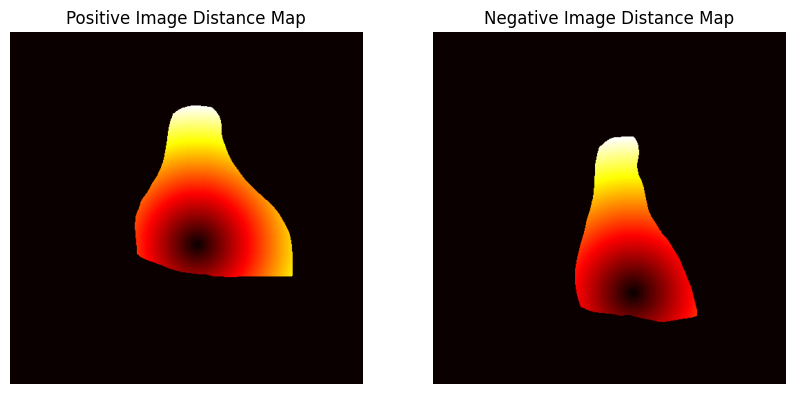

In [5]:
import src.features as feat
positive_map = feat.distance_map_center(positive)
negative_map = feat.distance_map_center(negative)

show.show_together(positive_map, "Positive Image Distance Map",
                   negative_map, "Negative Image Distance Map", map = 'hot')




# TUTAJ MOŻNA WPISYWAĆ INNE CECHY CO SIĘ CIEKAWE DO POKAZANIA
kolejność dowolna